In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.special import expit
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Load, Split, and Balance (1.5 points total)
##### **[.5 points]**
* (1) Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric.

In [2]:
#Read in the data
data = pd.read_csv('./acs2017_census_tract_data.csv', low_memory=False)
data.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


* (2) Remove any observations that having missing data.

In [3]:
# data.describe()
#Finding null values
print("Null Values before drop:\n")
print(data.isnull().sum())

data.dropna(axis=0,how="any",inplace=True)

print("\nNull Values after drop:\n")
print(data.isnull().sum())
# data.describe()

Null Values before drop:

TractId                0
State                  0
County                 0
TotalPop               0
Men                    0
Women                  0
Hispanic             696
White                696
Black                696
Native               696
Asian                696
Pacific              696
VotingAgeCitizen       0
Income              1116
IncomeErr           1116
IncomePerCap         745
IncomePerCapErr      745
Poverty              842
ChildPoverty        1110
Professional         811
Service              811
Office               811
Construction         811
Production           811
Drive                801
Carpool              801
Transit              801
Walk                 801
OtherTransp          801
WorkAtHome           801
MeanCommute          946
Employed               0
PrivateWork          811
PublicWork           811
SelfEmployed         811
FamilyWork           811
Unemployment         810
dtype: int64

Null Values after drop:

TractId   

* (3) Encode any string data as integers for now.

In [4]:
print("Categorical Features")
print(data.dtypes[data.dtypes != 'float64'][data.dtypes !='int64'])
data_cat = data.copy() # Will be used later
states = data["State"]
counties = data["County"]
data["State"] = data["State"].astype('category')
data["State"] = data["State"].cat.codes
data["County"] = data["County"].astype('category')
data["County"] = data["County"].cat.codes

print("Features After encoding")
print(data.dtypes[data.dtypes != 'float64'][data.dtypes !='int64'])

Categorical Features
State     object
County    object
dtype: object
Features After encoding
State      int8
County    int16
dtype: object


* (4) You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We decided to remove the county data because we determined that it would not be as relevant as the other attributes in our dataset. Furthermore, we realized that if we were to keep it, we would need to one hot encode it as it is a cetegorical data type which would increase the number of attributes in our data signifigantly. Since a neural network's time complexist is based on the number of attributes, we decided that it would make more sense to remove the county variable completely.<br/>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We chose to remove variables such as TractId because it is an ID number and not relevant as a predictor of our classes. We also removed things such as race because we wanted to try to stray away from the model picking up a racial bias and wanted it to focus more on variables such as income and the types of industry in the given county.<br/>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We also removed data such as how people commute to work as we determined that this data would not be very important in predicting child poverty as the types of commuting vary drastically and would only really help to determine if a county has most of the population in a city or not and it is not a good indicator as to whether or not a county will have high child poverty. It was also necessary to convert data such as number of Men and number of Women to be percentages so that they were somewhat normalized because without doing this, then a county with a higher population will appear to have more women and men than another county with lower pop. Finally, we removed data about the number of people over the age of 16 who are employed because it is already accounted for in the unemployment rate attribute and by leaving it in, we would create a stronger bias for that data without meaning to.<br/>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__NOTE:__ It may be worth while to add this data in back in the end to see if it was increases our accuracy but for now, we will leave it out. 

In [5]:
#Data Cleaning
#Drop Non important columns
data.drop(columns=['TractId','Hispanic','White','Black','Native','Asian','Pacific','Employed','MeanCommute','OtherTransp','Walk','Transit','Carpool','Drive','County'],inplace=True)


#Numerical Data into percentages so that it is not skewed by population
data['Men'] = data['Men'] / data['TotalPop']
data['Women'] = data['Women'] / data['TotalPop']
data['VotingAgeCitizen'] = data['VotingAgeCitizen'] / data['TotalPop']
data.describe()

,State,TotalPop,Men,Women,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,...,Service,Office,Construction,Production,WorkAtHome,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,...,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000
mean,24.340370,4443.485121,0.491322,0.508678,0.717249,61119.999326,9690.325642,30666.653222,4249.725969,16.046724,...,18.847948,23.413165,9.263044,12.922312,4.612646,79.511827,14.149495,6.167661,0.171231,7.224917
std,15.102552,2190.183318,0.040244,0.040244,0.104256,30511.062580,6119.407315,15844.127467,2991.009809,12.428643,...,7.969609,5.591354,5.943849,7.592511,3.770733,7.957350,7.164790,3.798703,0.451630,5.099419
min,0.000000,58.000000,0.037275,0.006886,0.083826,2692.000000,728.000000,1631.000000,351.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,17.500000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,2958.000000,0.469348,0.488619,0.672307,40380.000000,5737.000000,20624.000000,2508.000000,6.900000,...,13.300000,19.700000,5.000000,7.200000,2.000000,75.300000,9.300000,3.500000,0.000000,3.900000
50%,24.000000,4137.000000,0.490761,0.509239,0.739374,54413.000000,8268.000000,27249.000000,3404.000000,12.600000,...,17.700000,23.200000,8.400000,11.800000,3.800000,80.600000,13.000000,5.500000,0.000000,6.000000
75%,38.000000,5532.750000,0.511381,0.530652,0.783471,74688.000000,11909.000000,36413.000000,4959.000000,21.800000,...,23.200000,26.900000,12.500000,17.500000,6.300000,85.000000,17.600000,8.000000,0.000000,9.000000
max,51.000000,65528.000000,0.993114,0.962725,0.992776,249750.000000,153365.000000,220253.000000,84414.000000,100.000000,...,70.900000,72.300000,68.100000,60.500000,82.800000,100.000000,80.700000,47.400000,22.300000,62.800000


#### Determining the cutoff for our Categories of child poverty
##### [.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the dataset be done for both the training and testing set? Explain.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We decided to go with pandas built in qcut function which is able to evenly divide any given series into n bins. Since we want 4 types of targets, we gave the function the number 4 for n and it ends up being the cutoff for the quartile ranges of the data. Meaning that the first bin, low child poverty, is the values from the 0th to 25th quartile and the moderate variable is the values from the 25th quartile to the 50th so on and so forth. By doing this, we are left with a roughly equivalent number of entries in each target variable. This is extremely important for the training data because without it, the model could only be good at looking at low poverty rates and would have little data to go off of in the high or extreme categories for example. This idea is not so important for the testing data because when testing, the model should be able to generalize such that it does not need an equivalent number of each class as it is not actively learning from the data and would therefore not be skewed one way or the other. I would argue that it is almost beneficial to have an uneven number of each category in the testing set because that can show if the model is able to generalize well or not.

In [6]:
#Coming up with divisors for child poverty

tmp = pd.qcut(data['ChildPoverty'],4,labels=[1, 2, 3, 4])
# tmp = pd.qcut(data['ChildPoverty'],4,labels=['low','moderate','high','extreme'])
data['ChildPoverty'] = tmp
print(data.groupby(['ChildPoverty']).size())

ChildPoverty
1    18229
2    18171
3    18148
4    18170
dtype: int64


In [7]:
data.columns

Index(['State', 'TotalPop', 'Men', 'Women', 'VotingAgeCitizen', 'Income',
       'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'WorkAtHome', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment'],
      dtype='object')

##### [.5 points] Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing. There is NO NEED to split the data multiple times for this lab.

In [8]:
# One-Hot Encodes
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return res


train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print(f'Train_data shape: {train_data.shape} - {train_data.shape[0] / data.shape[0] * 100:.2f}% of original data')
print('Train_data classes:\n',train_data.groupby(['ChildPoverty']).size()) #Ensure that the number of classes stays relatively equivalent
print(f'\nTest_data shape: {test_data.shape} - {test_data.shape[0] / data.shape[0] * 100:.2f}% of original data')
print('Test_data classes:\n',test_data.groupby(['ChildPoverty']).size())

y_train = pd.DataFrame(train_data['ChildPoverty'])
y_train = y_train.values.ravel()
X_train = train_data.drop(columns=['ChildPoverty'],inplace=False)
X_train = np.array(X_train)
# y_train = encode_and_bind(y_train,'ChildPoverty')

y_test = pd.DataFrame(test_data['ChildPoverty'])
y_test = y_test.values.ravel()
X_test = test_data.drop(columns=['ChildPoverty'],inplace=False)

X_test=np.array(X_test)
# y_test = encode_and_bind(y_test,'ChildPoverty')


print()
print(f'Type of X: {type(X_train)}\nType of y: {type(y_train)}\n')

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Targets:', np.unique(y_train))
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

y_test = y_test - 1
print(np.unique(y_test))
y_train = y_train - 1
print(np.unique(y_train))

Train_data shape: (58174, 22) - 80.00% of original data
Train_data classes:
 ChildPoverty
1    14596
2    14447
3    14538
4    14593
dtype: int64

Test_data shape: (14544, 22) - 20.00% of original data
Test_data classes:
 ChildPoverty
1    3633
2    3724
3    3610
4    3577
dtype: int64

Type of X: <class 'numpy.ndarray'>
Type of y: <class 'numpy.ndarray'>

X_train: (58174, 21)
y_train: (58174,)
Targets: [1 2 3 4]
X_test: (14544, 21)
y_test: (14544,)
[0 1 2 3]
[0 1 2 3]


## Pre-processing and Initial Modeling (2.5 points total)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We will be using a two layer perceptron for the next few parts. The perceptron uses the following properties:
1. Vectorized Gradient Computation - DONE
2. Mini-Batching - TODO
3. Cross Entropy Loss - TODO
4. Proper Glorot Initialization - TODO
5. Sigmoids - DONE

##### Two Layer Perceptron Code

In [9]:
import numpy as np
from scipy.special import expit
import sys
import pandas as pd



class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,C=0.0,epochs=500,eta=0.001,random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
    @staticmethod
    def _encode_labels(y):
        return pd.get_dummies(y).values.T

    def _initialize_weights(self):
        W1_num_elems = (self.n_features_ + 1) * self.n_hidden
        W1 = np.random.uniform(-1.0,1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden,self.n_features_ + 1)

        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0,1.0,size=W2_num_elems)
        W2 = W2.reshape(self.n_output_,self.n_hidden + 1)
        return W1,W2
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new

    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))

    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

In [10]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # need to vectorize this computation!
        # See additional code and derivation below!

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        # print(f"========== A3.shapoe {A3.shape}")
        y_pred = np.argmax(A3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""

        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)

            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2


        return self

In [11]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)

        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T


        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [12]:
import matplotlib.pyplot as plt
params = dict(n_hidden=50,
              C=0, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

Epoch: 400/400

[1]
Accuracy: 0.25605060506050603


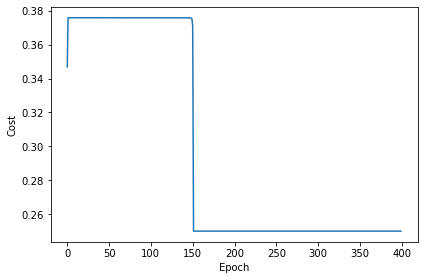

CPU times: user 2min 13s, sys: 7.11 s, total: 2min 20s
Wall time: 24.3 s


In [13]:
%%time
nn = TwoLayerPerceptronVectorized(**params)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)

print(np.unique(yhat))
print('Accuracy:',accuracy_score(y_test,yhat))

plt.plot(range(len(nn.cost_)),nn.cost_)
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

In [14]:
#Mini Batching
class MiniBatchedTwoLayer(TwoLayerPerceptronVectorized):
    def __init__(self,minibatches=1,shuffle=False,alpha=0.1,decrease_const=0.0, **kwargs):
        self.minibatches = minibatches
        self.shuffle = shuffle
        self.alpha = alpha
        self.decrease_const = decrease_const
        super().__init__(**kwargs)
    def fit(self,X,y,print_progress =0):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)


        self.cost_ = []

        for k in range(self.epochs):

            eta = self.eta **(1+self.decrease_const*k)
            eta = max(eta,self.eta/1000)

            if print_progress >0 and (k + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                # print(ridx)
                # print(f"X: {X_data.shape} | y: {Y_enc.shape} | y_data: {y_data.shape}")

                X_data, Y_enc = X_data[ridx], Y_enc[:,ridx]

            mini = np.array_split(range(y_data.shape[0]),self.minibatches)
            mini_cost = []
            for idx in mini:
                A1, Z1 ,A2 , Z2, A3 = self._feedforward(X_data[idx],
                                                        self.W1,
                                                        self.W2)

                cost = self._cost(A3,Y_enc[:,idx],self.W1,self.W2)
                mini_cost.append(cost)

                grad1, grad2 = self._get_gradient(A1=A1,A2=A2,A3=A3,Z1=Z1,Z2=Z2,Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)
                rho_W1,rho_W2 = eta * grad1, eta *grad2
                self.W1 -=(rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1,rho_W2


            self.cost_.append(mini_cost)
        return self







In [15]:
#Testing Mini Batching

params['epochs'] = 100
params['eta'] = 0.1

nn_mini = MiniBatchedTwoLayer(**params,
                              minibatches=len(X_train)/32,
                              shuffle=True)
nn_mini.fit(X_train,y_train,print_progress=25)
yhat = nn_mini.predict(X_test)

print(np.unique(yhat))
print(f'Accuracy: {accuracy_score(y_test,yhat)}')

Epoch: 100/100

[1 2 3]
Accuracy: 0.24525577557755776


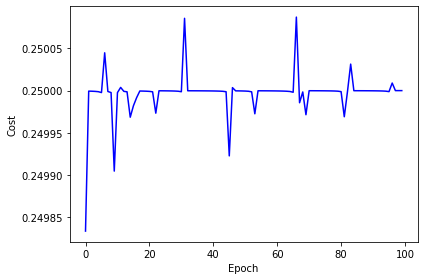

In [16]:
#Graphing Cost Funciton over Epochs

cost_avgs = [np.mean(x) for x in nn_mini.cost_]

plt.plot(range(len(cost_avgs)),cost_avgs, color='blue')
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

In [17]:
# Cross Entropy Loss
import math
class CrossEntropyLossTwoLayer(MiniBatchedTwoLayer):
    def  _cost(self,A3,Y_enc,W1,W2):
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc)*np.log(1-A3))))

        return cost
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        # print("============")

        V2 = (A3-Y_enc)
        V1 = A2*(1-A2) * (W2.T @V2)


        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T

        grad1[:,1:] += W1[:, 1:] * self.l2_C
        grad2[:,1:] += W2[:,1:] * self.l2_C

        return grad1,grad2

In [18]:
params['epochs'] = 100
params['eta'] = 0.1

nn_cross_entropy = CrossEntropyLossTwoLayer(**params,
                              minibatches=len(X_train)/32,
                              shuffle=True)
nn_cross_entropy.fit(X_train,y_train,print_progress=25)
yhat = nn_cross_entropy.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test,yhat)}')

/var/folders/m6/rmwt5gbx6dj274bh15l13lmc0000gn/T/ipykernel_87353/1304571784.py:5: RuntimeWarning: divide by zero encountered in log
  cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc)*np.log(1-A3))))
/var/folders/m6/rmwt5gbx6dj274bh15l13lmc0000gn/T/ipykernel_87353/1304571784.py:5: RuntimeWarning: invalid value encountered in multiply
  cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc)*np.log(1-A3))))
Epoch: 25/100/Users/kynerd/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
Epoch: 100/100

Accuracy: 0.2502062706270627


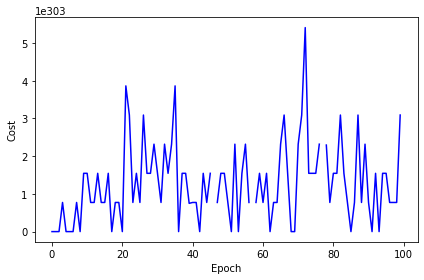

In [19]:
cost_avgs = [np.mean(x) for x in nn_cross_entropy.cost_]


# print(np.unique(cost_avgs))
plt.plot(range(len(cost_avgs)),cost_avgs, color='blue')
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

In [20]:
# Glorot initialization

class FullyFledgedTwoLayer(CrossEntropyLossTwoLayer):
    def _glorot_init_matrix(self,shape):
        fan_in, fan_out = shape[0],shape[1]
        variance = 2.0 / (fan_in + fan_out)
        std = np.sqrt(variance)
        return np.random.normal(loc=0.0,scale=std,size=shape)

    def _initialize_weights(self):
        W1 = self._glorot_init_matrix((self.n_hidden,self.n_features_ + 1))
        W2 = self._glorot_init_matrix((self.n_output_,self.n_hidden + 1))

        return W1,W2


In [21]:
# #Testing Using Dataset from Dr. Larson Example
#
# from sklearn.datasets import load_digits
#
# ds = load_digits()
# X = ds.data/16.0-0.5
# y=ds.target
#
# X_train,X_test,y_train,y_test = train_test_split(
#     X,y,test_size=0.2)
#
# params = dict(n_hidden=50,
#               C=0.1,
#               epochs=400,
#               eta=0.001,
#               random_state=1)
#
#
# nn = FullyFledgedTwoLayer(**params)
#
# nn.fit(X_train, y_train, print_progress=50)
# yhat = nn.predict(X_test)
#
# print(np.unique(yhat))
# print('Accuracy:',accuracy_score(y_test,yhat))
#
# plt.plot(range(len(nn.cost_)),nn.cost_)
# plt.ylabel("Cost")
# plt.xlabel("Epoch")
# plt.tight_layout()
# plt.show()

In [22]:
# If you update the objective function, you must also update the get gradient function

In [23]:
params = dict(C=0.1,
              epochs=100,
              eta=0.05,
              alpha=0.1,
              decrease_const=0.1,
              minibatches=50,
              shuffle=True,
              random_state=4)

##### **[.5 points]** Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs.

In [24]:
%%time
mlp1 = FullyFledgedTwoLayer(**params)

mlp1.fit(X_train, y_train)
yhat = mlp1.predict(X_test)

print("Accuracy:", accuracy_score(yhat, y_test))

/var/folders/m6/rmwt5gbx6dj274bh15l13lmc0000gn/T/ipykernel_87353/1304571784.py:5: RuntimeWarning: divide by zero encountered in log
  cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc)*np.log(1-A3))))
/var/folders/m6/rmwt5gbx6dj274bh15l13lmc0000gn/T/ipykernel_87353/1304571784.py:5: RuntimeWarning: invalid value encountered in multiply
  cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc)*np.log(1-A3))))
/Users/kynerd/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Accuracy: 0.24828107810781078
CPU times: user 30.2 s, sys: 627 ms, total: 30.8 s
Wall time: 5.2 s


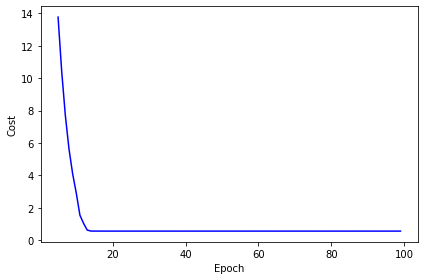

In [25]:
cost_avgs = [np.mean(x) for x in mlp1.cost_]

plt.plot(range(len(cost_avgs)),cost_avgs, color='blue')
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

##### **[.5 points]** Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.

In [26]:
print('X_train before normalization:', np.min(X_train), np.max(X_train))
print('X_test  before normalization:', np.min(X_test), np.max(X_test))

X_train = X_train / 249750.0 - 0.5
X_test  = X_test / 243194.0 - 0.5

print('X_train after normalization:', np.min(X_train), np.max(X_train))
print('X_test  after normalization:', np.min(X_test), np.max(X_test))

X_train before normalization: 0.0 249750.0
X_test  before normalization: 0.0 243194.0
X_train after normalization: -0.5 0.5
X_test  after normalization: -0.5 0.5


In [27]:
%%time
mlp2 = FullyFledgedTwoLayer(**params)

mlp2.fit(X_train, y_train)
yhat = mlp2.predict(X_test)

print("Accuracy:", accuracy_score(yhat, y_test))

/var/folders/m6/rmwt5gbx6dj274bh15l13lmc0000gn/T/ipykernel_87353/1304571784.py:5: RuntimeWarning: divide by zero encountered in log
  cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc)*np.log(1-A3))))
/var/folders/m6/rmwt5gbx6dj274bh15l13lmc0000gn/T/ipykernel_87353/1304571784.py:5: RuntimeWarning: invalid value encountered in multiply
  cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc)*np.log(1-A3))))
/Users/kynerd/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Accuracy: 0.22015951595159516
CPU times: user 37.3 s, sys: 1.24 s, total: 38.6 s
Wall time: 6.61 s


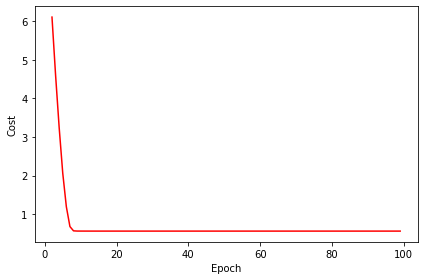

In [28]:
cost_avgs = [np.mean(x) for x in mlp2.cost_]

plt.plot(range(len(cost_avgs)),cost_avgs, color='red')
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

##### **[.5 points]** Now (1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Because we need to hot encode the categorical data, we need to go back to the point before we convert the categorical data into numerical. Now that we have the old data, we can go through the pre-processing again and normalize the numerical features and one-hot encode the categorical ones.

In [29]:
data = encode_and_bind(data_cat, 'State') ### one-hot encode the state column

#Data Cleaning
#Drop Non important columns
data.drop(columns=['TractId','Hispanic','White','Black','Native','Asian','Pacific','Employed','MeanCommute','OtherTransp','Walk','Transit','Carpool','Drive','County'],inplace=True)


#Numerical Data into percentages so that it is not skewed by population
data['Men'] = data['Men'] / data['TotalPop']
data['Women'] = data['Women'] / data['TotalPop']
data['VotingAgeCitizen'] = data['VotingAgeCitizen'] / data['TotalPop']
data.describe()

#Coming up with divisors for child poverty

tmp = pd.qcut(data['ChildPoverty'],4,labels=[1,2,3,4])
data['ChildPoverty'] = tmp

# split data

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

y_train = pd.DataFrame(train_data['ChildPoverty'])
y_train = y_train.values.ravel()
X_train = train_data.drop(columns=['ChildPoverty'],inplace=False)
X_train = np.array(X_train)

y_test = pd.DataFrame(test_data['ChildPoverty'])
y_test = y_test.values.ravel()
X_test = test_data.drop(columns=['ChildPoverty'],inplace=False)
X_test = np.array(X_test)

In [30]:
# normalize

X_train = X_train / 249750.0 - 0.5
X_test  = X_test / 243194.0 - 0.5

In [31]:
%%time
mlp3 = FullyFledgedTwoLayer(**params)

mlp3.fit(X_train, y_train)
yhat = mlp3.predict(X_test)

print("Accuracy:", accuracy_score(yhat, y_test))

/var/folders/m6/rmwt5gbx6dj274bh15l13lmc0000gn/T/ipykernel_87353/1304571784.py:5: RuntimeWarning: divide by zero encountered in log
  cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc)*np.log(1-A3))))
/var/folders/m6/rmwt5gbx6dj274bh15l13lmc0000gn/T/ipykernel_87353/1304571784.py:5: RuntimeWarning: invalid value encountered in multiply
  cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc)*np.log(1-A3))))
/Users/kynerd/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Accuracy: 0.24821232123212322
CPU times: user 54.5 s, sys: 2.56 s, total: 57.1 s
Wall time: 9.98 s


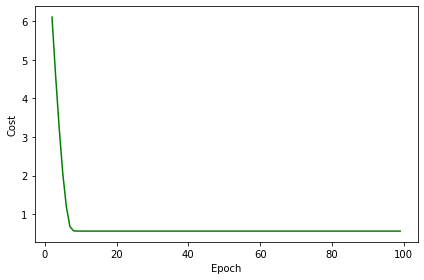

In [32]:
cost_avgs = [np.mean(x) for x in mlp2.cost_]

plt.plot(range(len(cost_avgs)),cost_avgs, color='green')
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

##### **[1 points]** Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
All three models have poor performace with accuracy lower than 25%, due to the fact that our activation function calculates roughly equal probabilties for each class. The raw model and normalized/encoded model have the same performance at 24.8%. The normalized (but not one-hot encoded) has a lower accuracy, likely due to predicting almost entirely one class, as in the other models, but with a few incorrect predictions. We are unsure why accuracy is so low, as our model works perfectly on the digits dataset, as seen below.

### Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.

### Modeling (5 points total)
##### **[1 points]** Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.
Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

##### **[1 points]** Repeat the previous step, adding support for a fourth layer.

##### **[1 points]** Repeat the previous step, adding support for a fifth layer.

In [33]:
class MiltiLayerNetwork(object):
    def __init__(self, hidden_layers,C=0.0,epochs=500,eta=0.001,random_state=None,minibatches=1,shuffle=False,alpha=0.1,
        decrease_const=0.0,verbose=False):
        np.random.seed(random_state)
        self.hidden_layers = hidden_layers
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.minibatches = minibatches
        self.shuffle = shuffle
        self.alpha = alpha
        self.verbose = verbose
        self.decrease_const = decrease_const

    def _encode_labels(self,y):
        return pd.get_dummies(y).values.T

    def _glorot_init_matrix(self,shape):
        fan_in, fan_out = shape[0],shape[1]
        variance = 2.0 / (fan_in + fan_out)
        std = np.sqrt(variance)
        return np.random.normal(loc=0.0,scale=std,size=shape)

    def _initialize_weights(self):

        weights = []

        prev_size = self.n_features_ 
        curr_size = self.hidden_layers[0]
        for i in range(len(self.hidden_layers)):
            weights.append(self._glorot_init_matrix((self.hidden_layers[i],prev_size + 1)))
            curr_size = self.hidden_layers[i]
            prev_size = curr_size

        weights.append(self._glorot_init_matrix((self.n_output_,curr_size + 1)))
        if self.verbose:
            print('Weights in initialize function')
            for idx,val in enumerate(weights):
                print(f'\t{idx}: {val.shape}')

        return weights

    def _feedforward(self,X, weights):
        
        # Weights in FeedForward Function
        #     0: (30, 65)
        #     1: (15, 31)
        #     2: (25, 31)
        #     3: (10, 26)
        # A_prev: (65, 1437)
        # A_prev: (65, 1437) | Z_prev: (30, 1437)
        # i: 1 | A_prev(65, 1437) | Z_prev: (30, 1437)
        # i: 2 | A_prev(31, 1437) | Z_prev: (15, 1437)
        A = []
        Z = []
        if self.verbose:
            print('Weights in FeedForward Function')
            for idx,val in enumerate(weights):
                print(f'\t{idx}: {val.shape}')

        A_prev = self._add_bias_unit(X.T,how='row')
        if self.verbose:
            print(f"A_prev: {A_prev.shape}")

        Z_prev = weights[0] @ A_prev

        if self.verbose:
            print(f'A_prev: {A_prev.shape} | Z_prev: {Z_prev.shape}')

        A.append(A_prev)
        Z.append(Z_prev)
        for i in range(1,len(weights)):
            if self.verbose:
                print(f'i: {i} | A_prev{A_prev.shape} | Z_prev: {Z_prev.shape}')
            A_tmp = self._sigmoid(Z_prev)
            A_tmp = self._add_bias_unit(A_tmp,how='row')
            Z_tmp = weights[i] @ A_tmp
            A.append(A_tmp)
            Z.append(Z_tmp)
            A_prev = A_tmp
            Z_prev = Z_tmp
        A.append(self._sigmoid(Z_prev))

        if self.verbose:
            print('A in feed forward')
            for idx,val in enumerate(A):
                print(f'\t{idx}: {val.shape}')
            print('Z in feed forward')
            for idx,val in enumerate(Z):
                print(f'\t{idx}: {val.shape}')
        return A,Z


    def fit(self,X,y,print_progress =0):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.weights = self._initialize_weights()

        # rho_W1_prev = np.zeros(self.W1.shape)
        # rho_W2_prev = np.zeros(self.W2.shape)
        rho_prev = [np.zeros(val.shape) for val in self.weights]
        self.grad_values_ = []
        self.cost_ = []

        for k in range(self.epochs):

            eta = self.eta **(1+self.decrease_const*k)
            eta = max(eta,self.eta/1000)

            if print_progress >0 and (k + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                # print(ridx)
                # print(f"X: {X_data.shape} | y: {Y_enc.shape} | y_data: {y_data.shape}")

                X_data, Y_enc = X_data[ridx], Y_enc[:,ridx]

            mini = np.array_split(range(y_data.shape[0]),self.minibatches)
            mini_cost = []
            grad_costs=[]
            for idx in mini:
                A_arr, Z_arr = self._feedforward(X_data[idx],
                                                        weights=self.weights)

                cost = self._cost(A_arr[-1],Y_enc[:,idx],self.weights)
                mini_cost.append(cost)

                grads = self._get_gradient(A=A_arr,Y_enc=Y_enc[:, idx],
                                                   weights=self.weights,Z=Z_arr)
                
                rho_new = [grad * eta for grad in grads]
                # self.grad_values_.append([np.mean(np.sqrt(val**2)) for val in grads])
                # grad_costs = np.append(grad_costs,[np.average(np.sqrt(val**2)) for val in grads])
                grad_costs.append([np.average(np.sqrt(val**2)) for val in grads])
                if self.verbose:
                    print(f'Rho_new')
                    for idx,val in enumerate(rho_new):
                        print(f'{idx}: {val.shape}')
                    print(f'rho_prev')
                    for idx,val in enumerate(rho_prev):
                        print(f'{idx}: {val.shape}')
                # print(self.grad_values_)
                self.weights = [self.weights[i] - (rho_new[i] + (self.alpha * rho_prev[i]) ) for i in range(len(grads))]
                rho_prev = rho_new

            # self.grad_values_ = np.append(self.grad_values_,grad_costs)
            self.grad_values_.append([np.average(val) for val in grad_costs])
            self.cost_.append(mini_cost)
        return self
        

    def _get_gradient(self,A,Z,Y_enc,weights):
        # In Get Gradient
        # A: 4
        #     0: (65, 1437)
        #     1: (31, 1437)
        #     2: (16, 1437)
        #     3: (10, 1437)
        # Z: 3
        #     0: (30, 1437)
        #     1: (15, 1437)
        #     2: (10, 1437)
        # weights: 3
        #     0: (30, 65)
        #     1: (15, 31)
        #     2: (10, 16)
        # Curr i: 1 | V_last: (10, 1437) | W.T (16, 10)
        # Curr i: 0 | V_last: (16, 1437) | W.T (31, 15)

        if self.verbose:
                    print(f'In Get Gradient')
                    print(f'A: {len(A)}')
                    for idx,val in enumerate(A):
                        print(f'\t{idx}: {val.shape}')
                    print(f'Z: {len(Z)}')
                    for idx,val in enumerate(Z):
                        print(f'\t{idx}: {val.shape}')
                    print(f'weights: {len(weights)}')
                    for idx,val in enumerate(weights):
                        print(f'\t{idx}: {val.shape}')
        grads = []

        V_last = A[-1]-Y_enc
        grad = V_last @ A[-2].T
        grad[:,1:] += weights[-1][:,1:] * self.l2_C
        grads.append(grad)


        for i in list(reversed(range(len(weights) - 1))):
            if self.verbose:
                print(f'Curr i: {i} | V_last: {V_last.shape} | W.T {weights[i + 1].T.shape}')

            V_new = A[i + 1] * (1-A[i + 1]) * (weights[i + 1].T @ V_last)
            grad = V_new[1:,:] @ A[i].T
            grad[:,1:] += weights[i][:,1:] * self.l2_C
            V_last = V_new[1:,:]
            grads.append(grad)
        # for i in list(reversed(range(len(A) - 1,1))):
        #     V_new = A[i] * (1-A[i]) * (weights[i - 1 ].T @ V_last)
        #     grad = V_new[1:,:] @ A[i-1].T
        #     grad[:,1:] += weights[i][:,1:] * self.l2_C
        #     grads.append(grad)


        if self.verbose:
            print('Grads in get_Gradient')
            for idx,val in enumerate(list(reversed(grads))):
                print(f'\t{idx}: {val.shape}')
        return list(reversed(grads))


    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new

    @staticmethod
    def _L2_reg(lambda_, weights):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        sqrts = np.sum([np.mean(W[:, 1:] ** 2) for W in weights])
        return (lambda_) * np.sqrt(sqrts)

    def _cost(self,A3,Y_enc,weights):
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc) * np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C,weights)
        return cost+L2_term

    def predict(self, X):
        """Predict class labels"""
        A,Z = self._feedforward(X, self.weights)
        # print(f"========== A3.shapoe {A3.shape}")
        for idx,val in enumerate(A):
            print(f'{idx}: {np.min(val)} | {np.max(val)} | {np.mean(val)} | {np.median(val)}')
        y_pred = np.argmax(A[-1], axis=0)
        print(f"A: {A[-1]}")
        return y_pred



##### **[2 points]** Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (such as AdaGrad, RMSProps, or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.

/var/folders/m6/rmwt5gbx6dj274bh15l13lmc0000gn/T/ipykernel_87353/122556950.py:243: RuntimeWarning: divide by zero encountered in log
  cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc) * np.log(1-A3))))
/var/folders/m6/rmwt5gbx6dj274bh15l13lmc0000gn/T/ipykernel_87353/122556950.py:243: RuntimeWarning: invalid value encountered in multiply
  cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc) * np.log(1-A3))))
/Users/kynerd/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
Epoch: 100/100

0: -0.5 | 1.0 | -0.47323367006507877 | -0.5
1: 4.580250140484136e-35 | 1.0 | 0.44476130040547746 | 0.06467573161522563
2: 0.0 | 1.0 | 0.2549324492472125 | 6.1617531899123345e-06
3: 0.24291055189184926 | 0.25519896758098426 | 0.24990566480914664 | 0.25073615340416894
A: [[0.24293335 0.24293198 0.24293218 ... 0.24293258 0.24293044 0.24292546]
 [0.24981906 0.24981703 0.24981729 ... 0.24981801 0.24981478 0.24980742]
 [0.25519772 0.25519707 0.25519718 ... 0.25519734 0.25519634 0.255194  ]
 [0.25167719 0.25167541 0.25167563 ... 0.25167627 0.25167343 0.25166697]]
[2]
Accuracy: 0.25605060506050603


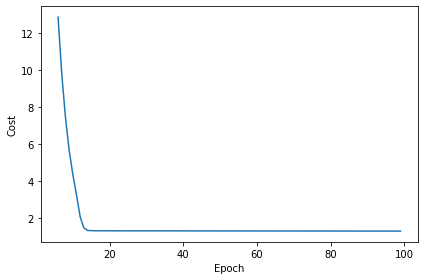

In [42]:
#Testing Using Dataset from Dr. Larson Example

from sklearn.datasets import load_digits



params = dict(
              C=0.1,
              epochs=100,
              eta=0.05,
              alpha=0.1,
              decrease_const=0.1,
              minibatches=50,
              shuffle=True,
              random_state=4)


nn = MiltiLayerNetwork(hidden_layers=[100,50],verbose=False,**params)



nn.fit(X_train, y_train, print_progress=25)
yhat = nn.predict(X_test)

print(np.unique(yhat))
print('Accuracy:',accuracy_score(y_test,yhat))


cost_avgs = [np.mean(x) for x in nn.cost_]

plt.plot(range(len(cost_avgs)),cost_avgs)
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

In [35]:
class TestNetwork(MiltiLayerNetwork):
    def _get_gradient(self,A,Z,Y_enc,weights):
        # In Get Gradient
        # A: 4
        #     0: (65, 1437)
        #     1: (31, 1437)
        #     2: (16, 1437)
        #     3: (10, 1437)
        # Z: 3
        #     0: (30, 1437)
        #     1: (15, 1437)
        #     2: (10, 1437)
        # weights: 3
        #     0: (30, 65)
        #     1: (15, 31)
        #     2: (10, 16)
        # Curr i: 1 | V_last: (10, 1437) | W.T (16, 10)
        # Curr i: 0 | V_last: (16, 1437) | W.T (31, 15)

        if self.verbose:
                    print(f'In Get Gradient')
                    print(f'A: {len(A)}')
                    for idx,val in enumerate(A):
                        print(f'\t{idx}: {val.shape}')
                    print(f'Z: {len(Z)}')
                    for idx,val in enumerate(Z):
                        print(f'\t{idx}: {val.shape}')
                    print(f'weights: {len(weights)}')
                    for idx,val in enumerate(weights):
                        print(f'\t{idx}: {val.shape}')
        grads = []

        V_last = -2 * (Y_enc - A[-1]) * A[-1] *(1-A[-1])
        grad = V_last @ A[-2].T
        grad[:,1:] += weights[-1][:,1:] * self.l2_C
        grads.append(grad)


        for i in list(reversed(range(len(weights) - 1))):
            if self.verbose:
                print(f'Curr i: {i} | V_last: {V_last.shape} | W.T {weights[i + 1].T.shape}')

            V_new = A[i + 1] * (1-A[i + 1]) * (weights[i + 1].T @ V_last)
            grad = V_new[1:,:] @ A[i].T
            grad[:,1:] += weights[i][:,1:] * self.l2_C
            V_last = V_new[1:,:]
            grads.append(grad)
        # for i in list(reversed(range(len(A) - 1,1))):
        #     V_new = A[i] * (1-A[i]) * (weights[i - 1 ].T @ V_last)
        #     grad = V_new[1:,:] @ A[i-1].T
        #     grad[:,1:] += weights[i][:,1:] * self.l2_C
        #     grads.append(grad)


        if self.verbose:
            print('Grads in get_Gradient')
            for idx,val in enumerate(list(reversed(grads))):
                print(f'\t{idx}: {val.shape}')
        return list(reversed(grads))

    def _cost(self,A3,Y_enc,weights):
        # cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc) * np.log(1-A3))))
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C,weights)
        return cost+L2_term

    def _initialize_weights(self):

        weights = []

        prev_size = self.n_features_ 
        curr_size = self.hidden_layers[0]
        for i in range(len(self.hidden_layers)):
            # weights.append(self._glorot_init_matrix((self.hidden_layers[i],prev_size + 1)))
            # weights.append(np.random.uniform(-1.0,1.0,size=self.hidden_layers[i] * (prev_size + 1)).reshape(self))
            weight_size = self.hidden_layers[i] * (prev_size + 1)
            weight = np.random.uniform(-1.0,1.0,size=weight_size)
            weight = weight.reshape(self.hidden_layers[i],prev_size + 1)
            weights.append(weight)
            curr_size = self.hidden_layers[i]
            prev_size = curr_size

        weight_size = self.n_output_ * (prev_size + 1)
        weight = np.random.uniform(-1.0,1.0,size=weight_size)
        weight = weight.reshape(self.n_output_,prev_size + 1)
        weights.append(weight)
        # weights.append(self._glorot_init_matrix((self.n_output_,curr_size + 1)))
        if self.verbose:
            print('Weights in initialize function')
            for idx,val in enumerate(weights):
                print(f'\t{idx}: {val.shape}')

        return weights

Epoch: 100/100

0: -0.5 | 1.0 | -0.47323367006507877 | -0.5
1: 0.01089402294679081 | 1.0 | 0.47772437601478696 | 0.4562596876413449
2: 0.009415384812884758 | 1.0 | 0.3634452426719103 | 0.2759862076243353
3: 3.44422239051365e-11 | 2.5020277454438015e-09 | 8.007411435808537e-10 | 3.332473024872381e-10
A: [[2.50202775e-09 2.50202775e-09 2.50202775e-09 ... 2.50202775e-09
  2.50202775e-09 2.50202775e-09]
 [2.08403160e-10 2.08403160e-10 2.08403160e-10 ... 2.08403160e-10
  2.08403160e-10 2.08403160e-10]
 [3.44422239e-11 3.44422239e-11 3.44422239e-11 ... 3.44422239e-11
  3.44422239e-11 3.44422239e-11]
 [4.58091445e-10 4.58091445e-10 4.58091445e-10 ... 4.58091445e-10
  4.58091445e-10 4.58091445e-10]]
[0]
Accuracy: 0.0


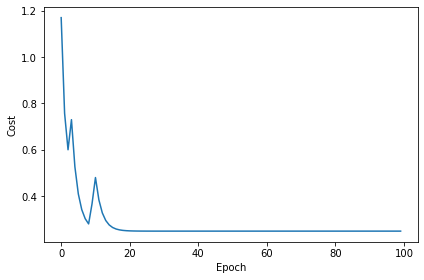

In [36]:
params = dict(
              C=0.1,
              epochs=100,
              eta=0.1,
              alpha=0.1,
              decrease_const=0.001,
              minibatches=50,
              shuffle=True,
              random_state=1)


nn = TestNetwork(hidden_layers=[100,50],verbose=False,**params)

nn.fit(X_train, y_train, print_progress=25)
yhat = nn.predict(X_test)

print(np.unique(yhat))
print('Accuracy:',accuracy_score(y_test,yhat))


cost_avgs = [np.mean(x) for x in nn.cost_]

plt.plot(range(len(cost_avgs)),cost_avgs)
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

In [37]:
print(np.unique(yhat))
print(np.unique(y_train))
print(np.unique(y_test))

[0]
[1 2 3 4]
[1 2 3 4]


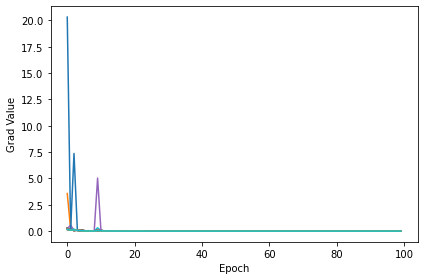

In [38]:
plt.plot(range(len(nn.grad_values_)),nn.grad_values_)
plt.ylabel("Grad Value")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
params = dict(
              C=0.1,
              epochs=100,
              eta=0.05,
              alpha=0.1,
              decrease_const=0.1,
              minibatches=50,
              shuffle=True,
              random_state=4)

nn_3_layer = MiltiLayerNetwork(hidden_layers=[50,25],**params)
nn_4_layer = MiltiLayerNetwork(hidden_layers=[50,25,15],**params)
nn_5_layer = MiltiLayerNetwork(hidden_layers=[50,25,15,10],**params)

nn_3_layer.fit(X_train,y_train,print_progress=25)
nn_4_layer.fit(X_train,y_train,print_progress=25)
nn_5_layer.fit(X_train,y_train,print_progress=25)

/var/folders/m6/rmwt5gbx6dj274bh15l13lmc0000gn/T/ipykernel_87353/122556950.py:243: RuntimeWarning: divide by zero encountered in log
  cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc) * np.log(1-A3))))
/var/folders/m6/rmwt5gbx6dj274bh15l13lmc0000gn/T/ipykernel_87353/122556950.py:243: RuntimeWarning: invalid value encountered in multiply
  cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc) * np.log(1-A3))))
/Users/kynerd/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
Epoch: 100/100

In [47]:
y_hat_3 = nn_3_layer.predict(X_test)
y_hat_4 = nn_4_layer.predict(X_test)
y_hat_5 = nn_5_layer.predict(X_test)

print('Accuracy of 3 Hidden:',accuracy_score(y_test,y_hat_3))
print('Accuracy of 4 Hidden:',accuracy_score(y_test,y_hat_4))
print('Accuracy of 5 Hidden:',accuracy_score(y_test,y_hat_5))

0: -12.489439894762109 | 27.74983819448449 | 0.04232776551974864 | -0.11044017239211314
1: 1.2801186147050931e-70 | 1.0 | 0.46236495009113704 | 0.25577524237681515
2: 0.0 | 1.0 | 0.10796357097444596 | 3.8761325073644823e-10
3: 1.759187629467964e-05 | 0.9570307671345221 | 0.24934267881710473 | 0.14199902515302948
A: [[1.92523434e-02 3.60277686e-01 8.21571862e-02 ... 1.92389263e-02
  5.22154303e-01 7.97727994e-01]
 [7.25892138e-02 4.58821957e-01 6.11840121e-01 ... 7.26052889e-02
  3.07620206e-01 1.17829167e-01]
 [3.52013743e-01 9.80977424e-02 4.29960204e-01 ... 3.52184097e-01
  3.90988746e-02 6.07295116e-03]
 [5.81371255e-01 2.52149428e-04 5.61812228e-04 ... 5.81440592e-01
  1.48993295e-04 5.49513549e-05]]
0: -12.489439894762109 | 27.74983819448449 | 0.04232776551974864 | -0.11044017239211314
1: 5.1120240402142324e-05 | 1.0 | 0.5326542660369118 | 0.530357304424286
2: 6.162269237575329e-49 | 1.0 | 0.30240493044472105 | 0.0007781019830081482
3: 1.340900830324897e-203 | 1.0 | 0.063516038205

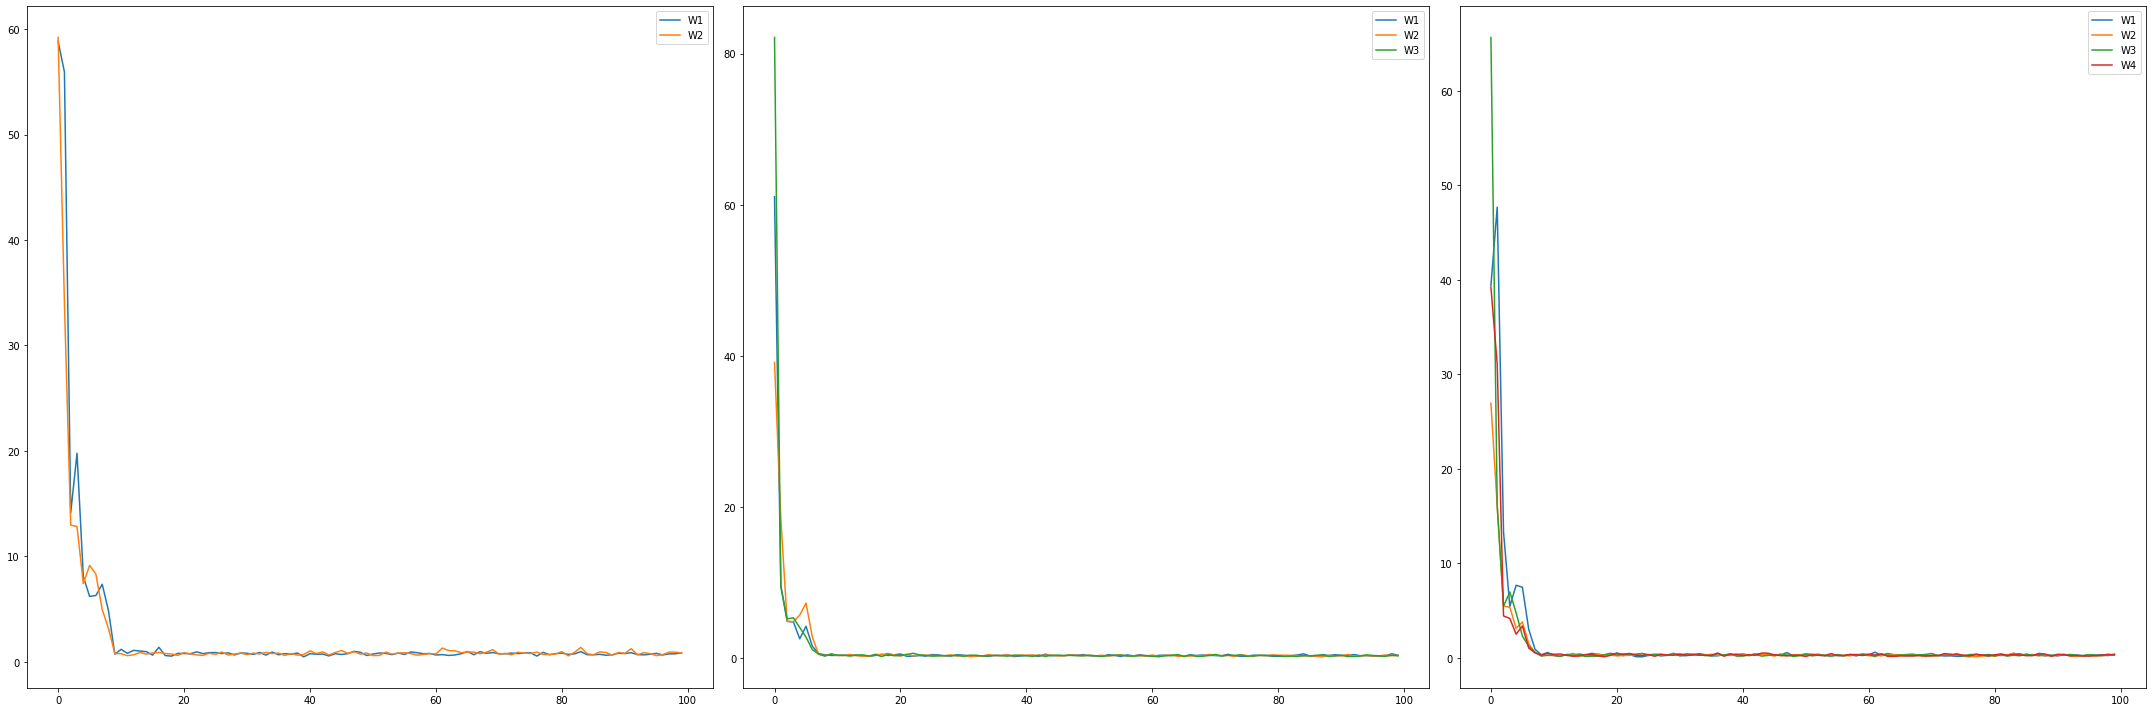

In [48]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=[30,10])

ax = ax.flatten()
# networks = [nn_3_layer,nn_4_layer,nn_5_layer]

tmp = np.array(nn_3_layer.grad_values_)
ax[0].plot(range(len(nn.grad_values_)),tmp[:,0],label='W1')
ax[0].plot(range(len(nn.grad_values_)),tmp[:,1],label='W2')
# ax[0].ylabel("Grad Value")
ax[0].legend()
# ax[0].xlabel("Epoch")

tmp = np.array(nn_4_layer.grad_values_)
ax[1].plot(range(len(nn.grad_values_)),tmp[:,1],label='W1')
ax[1].plot(range(len(nn.grad_values_)),tmp[:,0],label='W2')
ax[1].plot(range(len(nn.grad_values_)),tmp[:,2],label='W3')
# ax[1].ylabel("Grad Value")
ax[1].legend()
# ax[1].xlabel("Epoch")

tmp = np.array(nn_5_layer.grad_values_)
ax[2].plot(range(len(nn.grad_values_)),tmp[:,0],label='W1')
ax[2].plot(range(len(nn.grad_values_)),tmp[:,1],label='W2')
ax[2].plot(range(len(nn.grad_values_)),tmp[:,2],label='W3')
ax[2].plot(range(len(nn.grad_values_)),tmp[:,3],label='W4')
# ax[2].ylabel("Grad Value")
ax[2].legend()
# ax[2].xlabel("Epoch")


plt.tight_layout()
plt.show()
# # tmp = nn.grad_values_.reshape(2,2,2)

# Proof that our model works....

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[1 4 3 ... 3 4 3]
[2 9 5 ... 6 2 4]


Epoch: 400/400

0: -0.5 | 1.0 | -0.17495726495726496 | -0.4375
1: 1.0958605017362685e-05 | 1.0 | 0.30224689802314075 | 0.12109651672312244
2: 0.0002470009489801537 | 1.0 | 0.441021262055263 | 0.23121255494065426
3: 4.011767913373342e-08 | 0.9995632379133212 | 0.09857904061890073 | 0.0014359222661943132
A: [[5.68556266e-05 4.81787195e-02 1.72508335e-05 ... 1.96516163e-03
  6.98169168e-04 6.44989628e-04]
 [9.67328449e-02 1.52475575e-04 9.45756339e-01 ... 1.08758463e-03
  8.83900961e-03 1.23865273e-03]
 [3.88887246e-04 1.72267841e-01 2.99988434e-03 ... 9.97526565e-01
  2.18385667e-05 1.94054058e-01]
 ...
 [1.25014595e-04 2.75091924e-03 6.70391829e-03 ... 1.38651719e-03
  4.59193339e-03 1.53662594e-01]
 [7.75278046e-01 1.61603272e-03 1.13889749e-01 ... 3.15147188e-03
  3.60143786e-03 5.52617365e-03]
 [5.30681103e-02 1.68872810e-04 3.91435155e-04 ... 1.49465854e-05
  9.78341141e-01 1.66937799e-05]]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
Accuracy: 0.9833333333333333


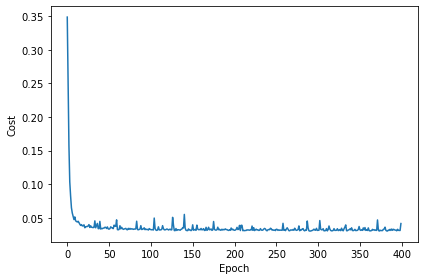

In [55]:
ds = load_digits()
X_digit = ds.data/16.0-0.5
y_digit=ds.target

X_train_d,X_test_d,y_train_d,y_test_d = train_test_split(
    X_digit,y_digit,test_size=0.2)

print(type(y_train))
print(type(y_train_d))
print(y_train)
print(y_train_d)

params = dict(
              C=0.01,
              epochs=400,
              eta=0.1,
              minibatches=50,
              shuffle=True,
              random_state=1)
nn = MiltiLayerNetwork(hidden_layers=[30,15],verbose=False,**params)

nn.fit(X_train_d, y_train_d, print_progress=50)
yhat = nn.predict(X_test_d)

print(np.unique(yhat))
print(np.unique(y_test_d))
print(np.unique(y_train_d))

print('Accuracy:',accuracy_score(y_test_d,yhat))

cost_avgs = [np.mean(x) for x in nn.cost_]

plt.plot(range(len(cost_avgs)),cost_avgs)
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

In [40]:
tmp = np.array(nn.grad_values_)
plt.plot(range(len(nn.grad_values_)),tmp[:,0],label='W1')
plt.plot(range(len(nn.grad_values_)),tmp[:,1],label='W2')
plt.ylabel("Grad Value")
plt.legend()
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()
# tmp = nn.grad_values_.reshape(2,2,2)

print(tmp.shape)

### Exceptional Work (1 points total)
5000 level student: You have free reign to provide additional analyses.
One idea (required for 7000 level students):  Implement adaptive momentum (AdaM) in the five layer neural network and quantify the performance.

In [44]:
# # Data from the notebook just to check that the functions are working and we have the same types for the X and y datasets

from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

ds = load_digits()
X = ds.data/16.0-0.5 # normalize the input, very important
y = ds.target

print(X.shape)
print(y.shape)
print(np.min(X),np.max(X))
print(np.unique(y))

from sklearn.model_selection import train_test_split

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    X,y,test_size = 0.2)

print('X_train:', X_train_num.shape)
print('y_train:', y_train_num.shape)
print('X_test:', X_test_num.shape)
print('y_test:', y_test_num.shape)

# nn.fit(X_train_num, y_train_num, print_progress=50)

(1797, 64)
(1797,)
-0.5 0.5
[0 1 2 3 4 5 6 7 8 9]
X_train: (1437, 64)
y_train: (1437,)
X_test: (360, 64)
y_test: (360,)
